In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from datetime import datetime
import os
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

# 1. Data Processing

In [2]:
def get_data(tickers, start, end):
    df = yf.download(tickers, start=start, end=end)['Close']
    log_returns = np.log(df / df.shift(1))
    log_returns.dropna(inplace=True)
    return df, log_returns

In [3]:
def fit_garch_multi(returns):
    volatilities = pd.DataFrame(index=returns.index, columns=returns.columns)
    models = {}
    for ticker in returns.columns:
        model = arch_model(returns[ticker] * 100, vol='Garch', p=2, q=2)
        res = model.fit(disp='off')
        models[ticker] = res
        volatilities[ticker] = res.conditional_volatility / 100
    return models, volatilities

In [ ]:
TICKERS = ["AAPL", "MSFT", "GOOGL", "BND", "TLT", "META", "NVDA", "AVGO", "LLY", "MGK", "MGC", "VOO", "SPY", "QQQ", "IYW", "^GSPC"]
START = datetime(2015, 1, 1)
END = datetime.today()

In [24]:
prices, returns = get_data(TICKERS, START, END)
prices, returns

[*********************100%***********************]  17 of 17 completed


(Ticker            AAPL        AVGO       AVUQ        BND       GOOGL  \
 Date                                                                   
 2015-01-02   24.261045    7.587782        NaN  61.378395   26.319653   
 2015-01-05   23.577576    7.466487        NaN  61.556576   25.818161   
 2015-01-06   23.579798    7.296674        NaN  61.734852   25.180981   
 2015-01-07   23.910435    7.493780        NaN  61.771980   25.106926   
 2015-01-08   24.829130    7.868278        NaN  61.675430   25.194403   
 ...                ...         ...        ...        ...         ...   
 2025-08-08  229.090012  304.970001  56.799000  73.419998  201.419998   
 2025-08-11  227.179993  303.899994  56.601002  73.470001  201.000000   
 2025-08-12  229.649994  312.829987  57.424000  73.480003  203.339996   
 2025-08-13  233.330002  309.089996  57.414001  73.750000  201.960007   
 2025-08-14  232.779999  311.230011  57.460999  73.540001  202.940002   
 
 Ticker             IYW         LLY        META  

In [6]:
_, volatilities = fit_garch_multi(returns)
volatilities

Ticker,AAPL,AVGO,BND,GOOGL,IYW,LLY,META,MGC,MGK,MSFT,NVDA,QQQ,SPY,TLT,VOO,^GSPC
Date,,,,,,,,,,,,,,,,
2015-01-05,0.019925,0.022585,0.002467,0.015627,0.012516,0.010979,0.017421,0.010139,0.010199,0.020879,0.022343,0.011160,0.010294,0.011298,0.010240,0.010353
2015-01-06,0.021370,0.022160,0.002513,0.016307,0.013123,0.011074,0.017728,0.011893,0.011431,0.019653,0.022383,0.011871,0.012523,0.011681,0.012370,0.012600
2015-01-07,0.019595,0.022703,0.002570,0.017484,0.013617,0.010930,0.019336,0.011931,0.011906,0.019126,0.024992,0.012506,0.011950,0.012184,0.011841,0.011815
2015-01-08,0.019128,0.022892,0.002410,0.015610,0.012978,0.011059,0.018073,0.011454,0.011587,0.018109,0.026068,0.012380,0.011932,0.011504,0.011863,0.011740
2015-01-09,0.021958,0.026706,0.002382,0.016248,0.014554,0.012086,0.017367,0.012590,0.012672,0.019904,0.024928,0.013309,0.012978,0.011772,0.012896,0.012895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-08,0.021415,0.020772,0.003072,0.013971,0.011769,0.042522,0.036100,0.008801,0.011800,0.015528,0.023810,0.010716,0.008440,0.007578,0.008360,0.008188
2025-08-11,0.024435,0.020418,0.002913,0.017843,0.011486,0.032341,0.024939,0.008743,0.011262,0.014944,0.022857,0.010391,0.008343,0.007469,0.008276,0.008184
2025-08-12,0.022318,0.019669,0.002819,0.013922,0.011182,0.037220,0.025497,0.008280,0.010723,0.013849,0.022513,0.010010,0.007726,0.007235,0.007664,0.007620


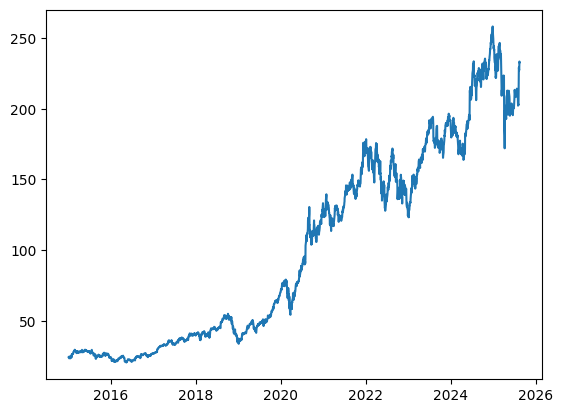

In [7]:
plt.plot(prices["AAPL"])

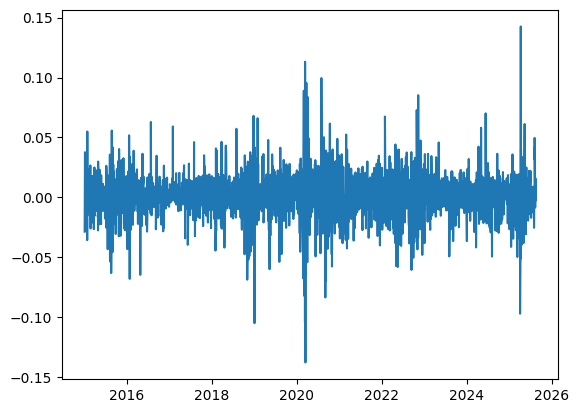

In [8]:
plt.plot(returns["AAPL"])

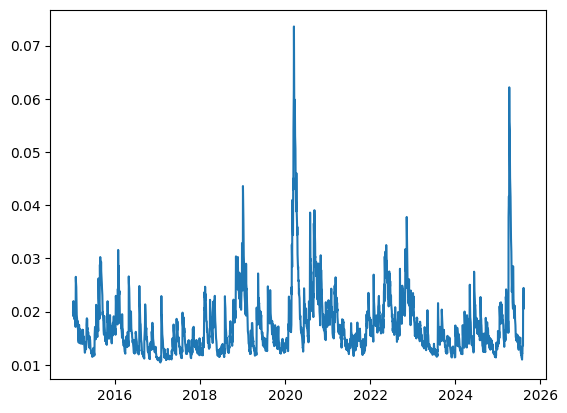

In [9]:
plt.plot(volatilities["AAPL"])

# 2. Environment Construction

In [ ]:
class PortfolioEnv(gym.Env):
    def __init__(self, log_returns, volatilities, risk_free_rate=0.02):
        super(PortfolioEnv, self).__init__()
        self.log_returns = log_returns.values
        self.volatilities = volatilities.values
        self.n_assets = log_returns.shape[1]
        self.n_steps = len(log_returns)
        self.risk_free_rate = risk_free_rate / 252
        self.portfolio_init_value = 10_000.0

        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets * 2,), dtype=np.float32)
        self.reset()

    def reset(self, *, seed=None, options=None):
        self.current_step = 0
        self.portfolio_value = self.portfolio_init_value
        self.weights = np.random.random(self.n_assets)
        return self._get_obs(), {}

    def _get_obs(self):
        current_returns = self.log_returns[self.current_step]
        current_vols = self.volatilities[self.current_step]
        return np.concatenate([current_returns, current_vols]).astype(np.float32)

    def step(self, action):
        self.current_step += 1  # use next day's returns

        action = np.clip(action, 0, None)
        self.weights = action / np.sum(action) if np.sum(action) > 0 else np.ones(self.n_assets) / self.n_assets

        port_return = np.dot(self.weights, np.exp(self.log_returns[self.current_step]) - 1)
        port_vol = np.sqrt(np.dot(self.weights**2, self.volatilities[self.current_step]**2))

        # Reward: daily sharpe ratio
        reward = (port_return - self.risk_free_rate) / port_vol if port_vol > 0 else 0

        self.portfolio_value *= (1 + port_return)

        done = self.current_step >= self.n_steps - 1
        truncated = False
        info = { "PortValue": self.portfolio_value, "PortReturn": (100 * (self.portfolio_value - self.portfolio_init_value) / self.portfolio_init_value), "PortWeights": self.weights }

        return self._get_obs(), reward, done, truncated, info

In [11]:
log_returns = pd.read_csv(os.path.join("..", "data", "train_returns.csv"))
vol = pd.read_csv(os.path.join("..", "data", "train_vols.csv"))

In [12]:
log_returns

,AAPL,AVGO,BND,GOOGL,IYW,LLY,META,MGC,MGK,MSFT,NVDA,QQQ,SPY,TLT,VOO
0,-0.028576,-0.016115,0.002900,-0.019238,-0.016081,-0.009898,-0.016191,-0.017689,-0.016667,-0.009238,-0.017035,-0.014777,-0.018225,0.015587,-0.017725
1,0.000094,-0.023006,0.002891,-0.024989,-0.013667,0.005033,-0.013565,-0.009037,-0.010211,-0.014786,-0.030788,-0.013499,-0.009464,0.017856,-0.009882
2,0.013925,0.026655,0.000601,-0.002945,0.008380,-0.007053,0.000000,0.011790,0.012842,0.012625,-0.002609,0.012808,0.012384,-0.001976,0.012418
3,0.037703,0.048766,-0.001564,0.003478,0.024630,0.023413,0.026309,0.017214,0.017239,0.028994,0.036927,0.018959,0.017590,-0.013332,0.017415
4,0.001072,0.010638,0.001685,-0.012286,-0.003838,-0.013352,-0.005644,-0.007997,-0.008148,-0.008440,0.004020,-0.006604,-0.008046,0.010893,-0.008456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,0.016257,0.021629,0.000000,0.005157,0.018899,0.017193,-0.010321,0.013759,0.013800,0.028480,0.030927,0.012473,0.014314,0.003193,0.014172
2000,0.006759,0.025558,0.006811,0.024559,0.016813,-0.023668,0.046334,0.007922,0.012163,0.017314,0.030165,0.010693,0.007541,0.009609,0.007363
2001,-0.015658,0.005937,0.002441,-0.005873,-0.007454,0.013404,0.011914,-0.006188,-0.007063,0.001167,-0.022269,-0.007442,-0.006414,0.004262,-0.006055
2002,-0.047987,-0.029037,0.000541,-0.045294,-0.039685,-0.009647,-0.045772,-0.025290,-0.033676,-0.032439,-0.041709,-0.034153,-0.024766,0.003894,-0.024902


# 3. Model Setup and Training

In [13]:
env = make_vec_env(lambda: PortfolioEnv(log_returns, vol), n_envs=1)

In [14]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100_000)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 182      |
| time/              |          |
|    fps             | 7338     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2e+03       |
|    ep_rew_mean          | 184         |
| time/                   |             |
|    fps                  | 4434        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007082427 |
|    clip_fraction        | 0.0491      |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.3       |
|    explained_variance   | 0.000264    |
|    learning

In [16]:
test_returns = pd.read_csv(os.path.join("..", "data", "test_returns.csv"))
test_vols = pd.read_csv(os.path.join("..", "data", "test_vols.csv"))

In [17]:
test_returns.shape, test_vols.shape

((399, 15), (399, 15))

In [18]:
test_returns

,AAPL,AVGO,BND,GOOGL,IYW,LLY,META,MGC,MGK,MSFT,NVDA,QQQ,SPY,TLT,VOO
0,-0.003228,0.017803,0.005197,-0.001407,0.004406,0.008737,-0.002162,0.000647,0.002147,0.004848,0.008647,0.002079,-0.000441,0.005599,-0.000343
1,0.001777,0.006976,0.002044,0.004004,0.002602,0.011262,0.012954,0.001292,0.001378,0.009934,-0.002045,0.000513,0.000693,-0.001966,0.000457
2,-0.012393,0.006551,-0.007104,-0.001122,0.001785,-0.013073,-0.018951,-0.003528,-0.000689,0.004623,0.030104,-0.000098,-0.003678,-0.017770,-0.003408
3,-0.005187,-0.010178,-0.002334,-0.007184,-0.005365,-0.008960,0.002473,-0.004664,-0.005219,-0.002052,-0.005852,-0.005657,-0.005574,-0.001583,-0.005583
4,0.032052,0.035811,-0.001375,0.014108,0.019051,-0.008880,0.020847,0.009131,0.014514,0.011234,0.018629,0.014094,0.008853,-0.009339,0.008853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0.041485,0.003975,-0.002177,0.024628,0.009890,-0.024020,0.009758,0.009406,0.009337,0.002301,0.010620,0.009285,0.007767,-0.004344,0.007626
395,-0.008372,-0.003515,0.000681,-0.002087,-0.005561,0.015180,-0.004469,-0.001848,-0.001819,-0.000517,-0.003509,-0.002963,-0.001979,0.001145,-0.002051
396,0.010814,0.028961,0.000136,0.011575,0.014169,0.006606,0.031021,0.010187,0.010091,0.014215,0.006024,0.012490,0.010590,-0.005048,0.010619
397,0.015897,-0.012027,0.003668,-0.006810,-0.000971,0.032405,-0.012636,0.001319,0.000129,-0.016498,-0.008609,0.000500,0.003417,0.008247,0.003481


In [22]:
cum = returns.tail(399).cumsum()
(np.exp(cum["^GSPC"].iloc[-1]) - 1) * 100

np.float64(35.22749845710295)

# 4. Model Testing + Evaluation

In [20]:
env = make_vec_env(lambda: PortfolioEnv(test_returns, test_vols), n_envs=1)

In [26]:
episodes = 100
total_returns = 0
for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
    total_returns += round(info[0]["PortReturn"], 2)
    print("Episode: {} | Portfolio Value: ${:,} | Portfolio Return: {}%".format(episode, round(info[0]["PortValue"], 2), round(info[0]["PortReturn"], 2)))
print("Average Portfolio Return: {}%".format(round(total_returns / episodes, 2)))

Episode: 1 | Portfolio Value: $17,030.26 | Portfolio Return: 70.3%
Episode: 2 | Portfolio Value: $15,661.99 | Portfolio Return: 56.62%
Episode: 3 | Portfolio Value: $13,557.13 | Portfolio Return: 35.57%
Episode: 4 | Portfolio Value: $14,957.96 | Portfolio Return: 49.58%
Episode: 5 | Portfolio Value: $14,846.4 | Portfolio Return: 48.46%
Episode: 6 | Portfolio Value: $15,613.98 | Portfolio Return: 56.14%
Episode: 7 | Portfolio Value: $14,980.32 | Portfolio Return: 49.8%
Episode: 8 | Portfolio Value: $16,176.94 | Portfolio Return: 61.77%
Episode: 9 | Portfolio Value: $17,127.24 | Portfolio Return: 71.27%
Episode: 10 | Portfolio Value: $12,680.01 | Portfolio Return: 26.8%
Episode: 11 | Portfolio Value: $18,194.55 | Portfolio Return: 81.95%
Episode: 12 | Portfolio Value: $14,536.19 | Portfolio Return: 45.36%
Episode: 13 | Portfolio Value: $15,746.14 | Portfolio Return: 57.46%
Episode: 14 | Portfolio Value: $20,166.51 | Portfolio Return: 101.67%
Episode: 15 | Portfolio Value: $16,115.93 | Po

# 5. Backtesting